+ cam0=[1758.23 0 872.36; 0 1758.23 552.32; 0 0 1]
+ cam1=[1758.23 0 872.36; 0 1758.23 552.32; 0 0 1]
+ doffs=0
+ baseline=124.86
+ width=1920
+ height=1080
+ ndisp=310
+ vmin=90
+ vmax=280

In [1]:
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im1.png # right
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im0.png # left
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/disp0.pfm # left
!wget https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/disp1.pfm # right

--2022-05-05 13:40:50--  https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im1.png
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588198 (2.5M) [image/png]
Saving to: ‘im1.png’

im1.png             100%[===================>]   2.47M   238KB/s    in 13s     

2022-05-05 13:41:05 (192 KB/s) - ‘im1.png’ saved [2588198/2588198]

--2022-05-05 13:41:05--  https://vision.middlebury.edu/stereo/data/scenes2021/data/chess2/im0.png
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2547220 (2.4M) [image/png]
Saving to: ‘im0.png’

im0.png             100%[===================>]   2.43M   430KB/s    in 7.1s    

2022-05-05 13:41:14 (349 KB/s) - ‘

In [2]:
!pip install kornia

You should consider upgrading via the '/home/mohammadreza/Project/UnDeepVO/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import cv2
import os
import sys
import torch
import torchvision
import kornia
import kornia as K
import tensorflow as tf
from tensorflow.keras import layers
from torchvision import transforms

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

2022-05-05 13:42:12.478169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mohammadreza/Project/UnDeepVO/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-05 13:42:12.478247: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
focal = 1758.23
baseline = 124.86

In [5]:
def data_to_vis(tensor):
    return kornia.tensor_to_image(tensor)

In [6]:
right_depth: np.array = cv2.imread('/content/disp1.pfm', cv2.IMREAD_UNCHANGED)
left_depth: np.array = cv2.imread('/content/disp0.pfm', cv2.IMREAD_UNCHANGED)

right_depth[right_depth==np.inf] = 0
right_depth: np.array = cv2.normalize(right_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

left_depth[left_depth==np.inf] = 0
left_depth: np.array = cv2.normalize(left_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

right: np.array = cv2.imread('/content/im1.png')
left: np.array = cv2.imread('/content/im0.png')

right: np.array = cv2.normalize(right, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
left: np.array = cv2.normalize(left, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

[ WARN:0@5.889] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/content/disp1.pfm'): can't open/read file: check file path/integrity
[ WARN:0@5.890] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/content/disp0.pfm'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object does not support item assignment

In [7]:
right_camera_matrix = np.array([
    [1758.23, 0, 872.36],
    [0, 1758.23, 552.32],
    [0, 0, 1]
])

left_camera_matrix = np.array([
    [1758.23, 0, 872.36],
    [0, 1758.23, 552.32],
    [0, 0, 1]
])

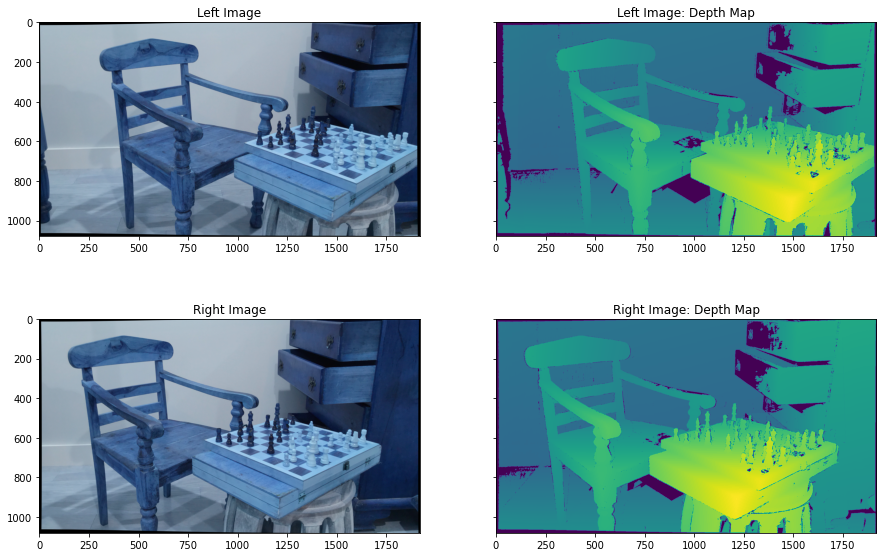

In [8]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0, 0].imshow(left)
axes[0, 0].set_title('Left Image')

axes[0, 1].imshow(left_depth)
axes[0, 1].set_title('Left Image: Depth Map')

axes[1, 0].imshow(right)
axes[1, 0].set_title('Right Image')

axes[1, 1].imshow(right_depth)
axes[1, 1].set_title('Right Image: Depth Map')

plt.show()

In [9]:
left: torch.tensor = K.image_to_tensor(left)  # CxHxW / torch.uint8
right: torch.tensor = K.image_to_tensor(right)  # CxHxW / torch.uint8
left_depth: torch.tensor = K.image_to_tensor(left_depth)  # CxHxW / torch.uint8
right_depth: torch.tensor = K.image_to_tensor(right_depth)  # CxHxW / torch.uint8

In [10]:
transform = torchvision.transforms.ToTensor()

In [11]:
left_camera_matrix: torch.tensor = transform(left_camera_matrix)
right_camera_matrix: torch.tensor = transform(right_camera_matrix)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [13]:
left = left.to(device)
right = right.to(device)
left_depth = left_depth.to(device)
right_depth = right_depth.to(device)

In [14]:
left_camera_matrix = left_camera_matrix.to(device)
right_camera_matrix = right_camera_matrix.to(device)

In [119]:
# Camera transformation matrix between 
transform_from_left_to_right = torch.tensor(
    (
        (1, 0, 0, 10),
        (0, 1, 0, 0),
        (0, 0, 1, 0),
        (0, 0, 0, 1),
    )
)[None].to(device)
transform_from_left_to_right = transform_from_left_to_right.float()

In [16]:
left = left.float()
right = right.float()
left_depth = left_depth.float()
right_depth = right_depth.float()
left_camera_matrix = left_camera_matrix.float()
right_camera_matrix = right_camera_matrix.float()

In [17]:
camera_baseline = 124.86
focal_length = left_camera_matrix[0, 0, 0]
lambda_position, lambda_angle, lambda_s = 1e-3, 1e-3, 1e-2

In [18]:
left = left.expand(1, -1, -1, -1)
right = right.expand(1, -1, -1, -1)
left_depth = left_depth.expand(1, -1, -1, -1)
right_depth = right_depth.expand(1, -1, -1, -1)

# Predict left disparity using ground truth right disparity and estimated left depth


In [19]:
left_disparity = (baseline * focal) / left_depth
right_disparity = (baseline * focal) / right_depth

left_disparity[left_disparity==np.inf] = 1
right_disparity[right_disparity==np.inf] = 1

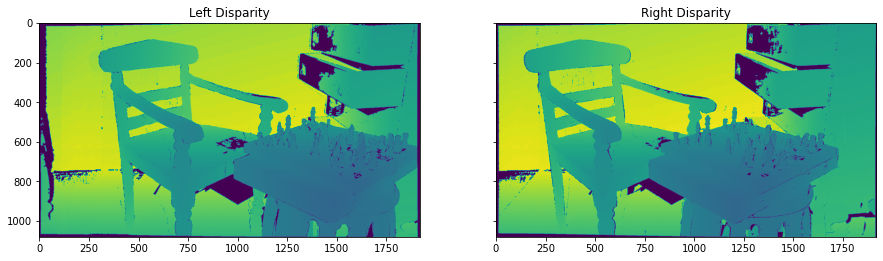

In [20]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].imshow(data_to_vis(left_disparity))
axes[0].set_title('Left Disparity')

axes[1].imshow(data_to_vis(right_disparity))
axes[1].set_title('Right Disparity')

plt.show()

In [120]:
generated_right_disparity  = kornia.geometry.warp_frame_depth(
    image_src=left_disparity,
    depth_dst=right_depth,
    src_trans_dst=transform_from_left_to_right,
    camera_matrix=left_camera_matrix,
    normalize_points=True
)

generated_left_disparity = kornia.geometry.warp_frame_depth(
    image_src=right_disparity,
    depth_dst=left_depth,
    src_trans_dst=torch.inverse(transform_from_left_to_right),
    camera_matrix=right_camera_matrix,
    normalize_points=True
)

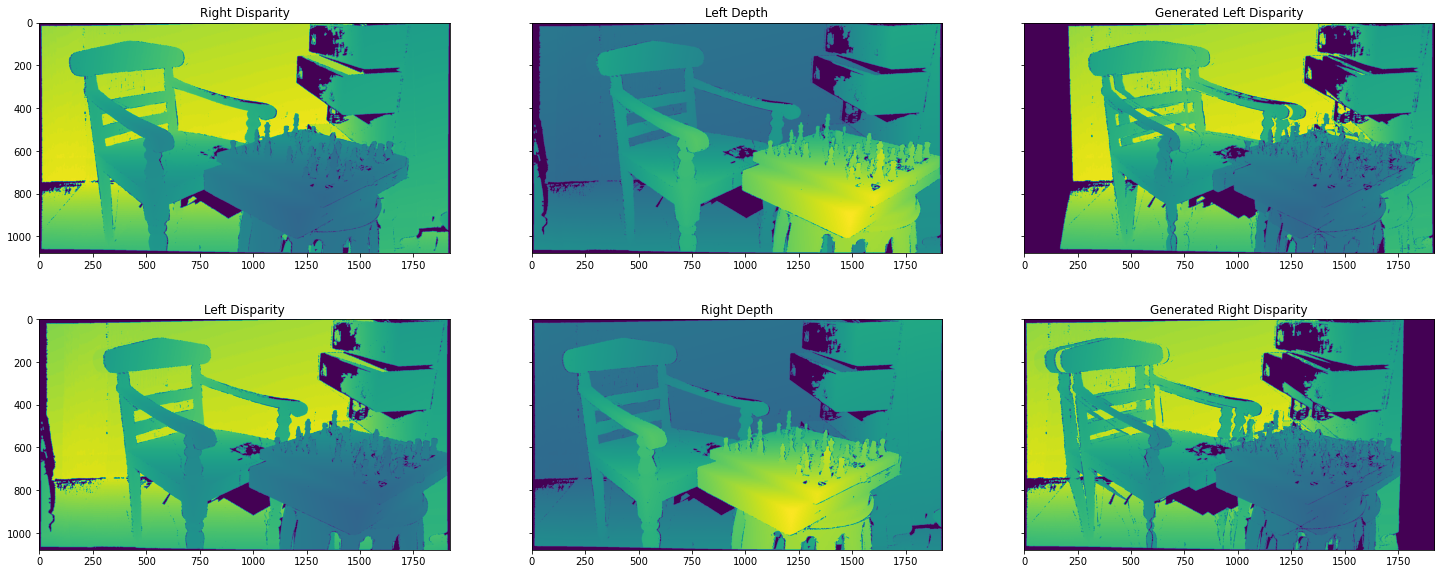

In [121]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(25)

axes[0, 0].imshow(data_to_vis(right_disparity))
axes[0, 0].set_title('Right Disparity')
axes[0, 1].imshow(data_to_vis(left_depth))
axes[0, 1].set_title('Left Depth')
axes[0, 2].imshow(data_to_vis(generated_left_disparity))
axes[0, 2].set_title('Generated Left Disparity')

axes[1, 0].imshow(data_to_vis(left_disparity))
axes[1, 0].set_title('Left Disparity')
axes[1, 1].imshow(data_to_vis(right_depth))
axes[1, 1].set_title('Right Depth')
axes[1, 2].imshow(data_to_vis(generated_right_disparity))
axes[1, 2].set_title('Generated Right Disparity')

plt.show()

In [122]:
loss = torch.nn.L1Loss()
output = loss(left_disparity, generated_left_disparity)
output

tensor(332.7490)

In [123]:
output = loss(right_disparity, generated_right_disparity)
output

tensor(293.8753)